# Boa noite,

começamos em breve.

Lembrete: https://forms.gle/EhjkK8RFvVe6vLUU9

In [14]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline

#---- declarando as funções que serão utilizadas ao longo do script ----#

def fix_pos(pos):
    """ funcao para corrigir os valores de coordenadas vindos no excel do IBAMA """
    # source: ttps://gist.github.com/ocefpaf/60bec6fbd252107de11073376bad7925
    deg, rest = pos.split("°")
    mi, rest = rest.strip().split("'")
    sec, hem = rest.strip().split('"')
    hem = hem.strip()

    deg, mi, sec = map(float, (deg, mi, sec))
    if hem in ["S", "W"]:
        sign = -1
    elif hem in ["N", "E"]:
        sign = +1
    else:
        raise ValueError(f"Unrecognized sign {sign}, expected 'S', 'W', 'E', or 'N'")

    return sign * (deg + mi/60 + sec/60/60)

###################################################

def make_map(fig=None, ax=None, extent=[-50,-41,-30,-22], projection=ccrs.PlateCarree()):
    """ 
    documente-a como exercício para entender a 
    ação de cada linha
    """
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    coastline_10m = cfeature.NaturalEarthFeature(
        category='physical',name='coastline',scale='10m',
        facecolor=cfeature.COLORS['land'])

    bathy_0m      = cfeature.NaturalEarthFeature(
        category='physical',name='bathymetry_L_0',scale='10m')

    # inserting information over the map
    ax.add_feature(coastline_10m, 
                   edgecolor='black',
                   linewidth=.1)
    ax.add_feature(bathy_0m,
                   facecolor='lightblue',
                   alpha=.3)
    
    return ax

###################################################

def configuring_map(ax, extent):
    # criando as gridlines 
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=.4, color='gray', 
                      alpha=0.5, linestyle='--', 
                      xlocs=np.linspace(extent[0], extent[1], 5),
                      ylocs=np.linspace(extent[3], extent[2], 5))

    gl.top_labels = False
    gl.right_labels = False

    # dicionario com configurações dos rótulos
    dict_style_labels = {
        'color': 'black',
        'fontsize': 8
    }

    gl.ylabel_style = dict_style_labels
    
###################################################

#---- começo do código principal ----#

url = "http://www.ibama.gov.br/phocadownload/emergenciasambientais/2019/manchasdeoleo/2019-12-02_LOCALIDADES_AFETADAS.xlsx"
df = pd.read_excel(
    url,
    parse_dates=["Data_Avist", "Data_Revis"],
)

# Calculando o tempo de permanência da mancha em cada localidade
df["dias"] = (df["Data_Revis"] - df["Data_Avist"]).dt.days

# tratando as colunas de tempo
df['Data_Avist'] = df['Data_Avist'].dt.strftime('%Y-%m-%d').str.replace('NaT', 'na')
df["Data_Revis"] = df["Data_Revis"].dt.strftime("%Y-%m-%d").str.replace("NaT", "na")
df["dias"] = df["dias"].astype(float)

df.dropna(inplace=True)
# um pouco de limpeza de dados (data cleaning)

# removendo linhas onde o status == nao observado
filtr = (df['Status'] == df['Status'].unique()[2])

df = df[~filtr].copy()

# removendo registros onde o dias == 0
filtr = (df['dias'] == 0)
df = df[~filtr].copy()

# necessário tratar as colunas de Latitude e Longitude
df['lat'] = df['Latitude'].apply(fix_pos)
df['lon'] = df['Longitude'].apply(fix_pos)

In [3]:
#----- visualizando -----#
extent = [-45.949, -30, -20, 0] # regiao brasileira

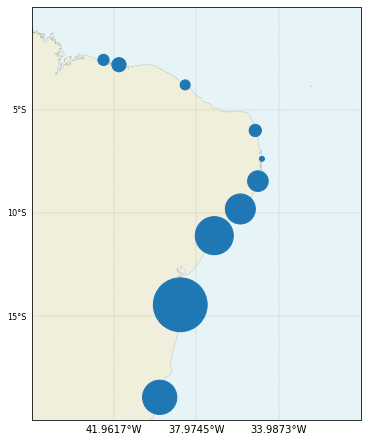

In [16]:
states = df.groupby('sigla_uf').count()
states['lat'] = df.groupby('sigla_uf').mean()['lat']
states['lon'] = df.groupby('sigla_uf').mean()['lon']
# (tamanho padrão de algumas revistas)
fig = plt.figure(figsize=(15/2.54,20/2.54)) # em polegadas 
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax = make_map(fig=fig, ax=ax, extent=extent, projection=ccrs.PlateCarree())
configuring_map(ax, extent=extent)
ax.scatter(states['lon'].values, states['lat'].values, 
           s=states['geocodigo'].values*25,  # o pulo do gato para variar o tamanho dos scatter
           zorder=50)
plt.savefig('lec06_ex01_resposta.png', dpi=150)

In [5]:
def extrair_info_UF(df, uf='AL'):
    df_por_estado = df[df['sigla_uf'] == uf]
    
    # limites geográficos com base no estado selecionado
    llon,ulon = df_por_estado['lon'].min(), df_por_estado['lon'].max()
    llat,ulat = df_por_estado['lat'].min(), df_por_estado['lat'].max()
    
    extent = [llon-0.05, ulon+0.05, llat-0.02, ulat+0.02]
    
    return df_por_estado, extent

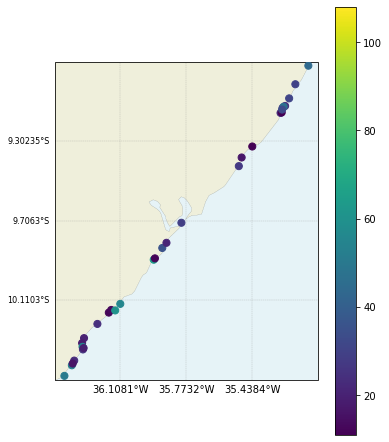

In [6]:
# Alagoas
alagoas,ext_alagoas = extrair_info_UF(df, uf='AL')
df_alagoas = alagoas.groupby('localidade').cumsum().copy()
fig = plt.figure(figsize=(15/2.54,20/2.54)) # em polegadas (tamanho padrão de algumas revistas)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax = make_map(fig=fig, ax=ax, extent=ext_alagoas, projection=ccrs.PlateCarree())
configuring_map(ax, extent=ext_alagoas)
cf = ax.scatter(df_alagoas['lon'], df_alagoas['lat'],
                s=50, zorder=20,
                c=df_alagoas['dias'])

plt.colorbar(cf)
plt.savefig('lec06_ex02_resposta_alagoas.png', dpi=150)

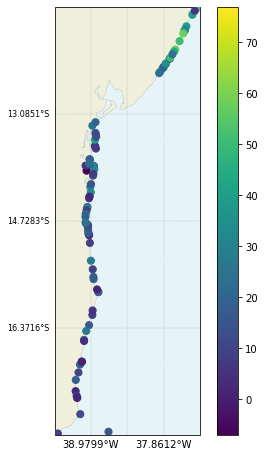

In [7]:
# Bahia
estado,ext_estado = extrair_info_UF(df, uf='BA')
df_estado = estado.groupby('localidade').cumsum().copy()
fig = plt.figure(figsize=(15/2.54,20/2.54)) # em polegadas (tamanho padrão de algumas revistas)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax = make_map(fig=fig, ax=ax, extent=ext_estado, projection=ccrs.PlateCarree())
configuring_map(ax, extent=ext_estado)
cf = ax.scatter(df_estado['lon'], df_estado['lat'],
                s=50, zorder=20,
                c=df_estado['dias'])

plt.colorbar(cf)
plt.savefig('lec06_ex02_resposta_bahia.png', dpi=150)

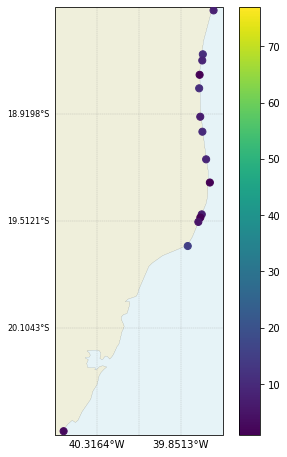

In [8]:
# Espirito Santo
estado,ext_estado = extrair_info_UF(df, uf='ES')
df_estado = estado.groupby('localidade').cumsum().copy()
fig = plt.figure(figsize=(15/2.54,20/2.54)) # em polegadas (tamanho padrão de algumas revistas)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax = make_map(fig=fig, ax=ax, extent=ext_estado, projection=ccrs.PlateCarree())
configuring_map(ax, extent=ext_estado)

cf = ax.scatter(df_estado['lon'], df_estado['lat'],
                s=50, zorder=20,
                c=df_estado['dias'])

plt.colorbar(cf)
plt.savefig('lec06_ex02_resposta_espiritosanto.png', dpi=150)

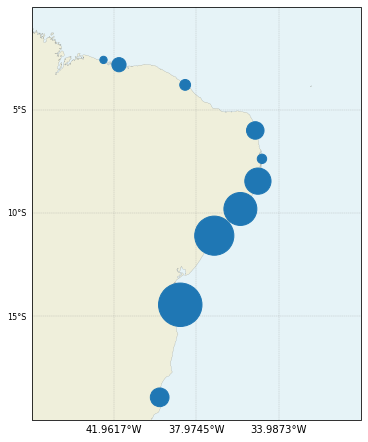

In [9]:
# 3) Utilize a coluna "dias" do dataframe e refaça o mapa 1), mas agora varie o tamanho dos marcadores 
# segundo o tempo de permanência somado dos Estados. Para isso use o agrupamento do pandas com o método 
# .sum().
# Estado mais afetado
states = df.groupby('sigla_uf').sum()
states['lat'] = df.groupby('sigla_uf').mean()['lat']
states['lon'] = df.groupby('sigla_uf').mean()['lon']
fig = plt.figure(figsize=(15/2.54,20/2.54)) # em polegadas (tamanho padrão de algumas revistas)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax = make_map(fig=fig, ax=ax, extent=extent, projection=ccrs.PlateCarree())
configuring_map(ax, extent=extent)
ax.scatter(states['lon'].values, states['lat'].values, 
           s=states['dias'].values,  # o pulo do gato para variar o tamanho dos scatter
           zorder=50)

## Campo multidimensionais (nD)

![](https://simulatingcomplexity.files.wordpress.com/2014/11/netcdf-file-structure.png)

**O que são campos multidimensionais?**

- 1D: série temporal ou perfil
- nD: multidimensional:
    - (tempo,profundidade), 
    - (tempo,latitude,longitude),
    - (tempo,profundidade,latitude,longitude)
    - etc
- modelos, satélites, etc

**Formato padrão de armazenamento**

- ASCII: legível, mas pesado (csv, dat)
- Binário: ilegível, mas leve (bin)
- NetCDF: combina o melhor dos mundos (nc, cdf)
- **Net**work **C**ommon **D**ata **F**ormat
    - atributos como metadados em ASCII
    - dados em binário

In [17]:
!ncdump -h ../dados/nino34_ERA5.nc

netcdf nino34_ERA5 {
dimensions:
	longitude = 201 ;
	latitude = 41 ;
	expver = 2 ;
	time = 500 ;
variables:
	float longitude(longitude) ;
		longitude:units = "degrees_east" ;
		longitude:long_name = "longitude" ;
	float latitude(latitude) ;
		latitude:units = "degrees_north" ;
		latitude:long_name = "latitude" ;
	int expver(expver) ;
		expver:long_name = "expver" ;
	int time(time) ;
		time:units = "hours since 1900-01-01 00:00:00.0" ;
		time:long_name = "time" ;
		time:calendar = "gregorian" ;
	short sst(time, expver, latitude, longitude) ;
		sst:scale_factor = 0.000162757933026109 ;
		sst:add_offset = 298.596354167908 ;
		sst:_FillValue = -32767s ;
		sst:missing_value = -32767s ;
		sst:units = "K" ;
		sst:long_name = "Sea surface temperature" ;

// global attributes:
		:Conventions = "CF-1.6" ;
		:history = "2020-09-30 21:02:53 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/data3/adaptor.mars.internal-1601499573.25794-28066-9-4d805da6-89b7-450e-

**Leitura de arquivos netcdf no python**

- netCDF4:
    - clássico e muito utilizado
    - matrizes numpy
- Xarray:
    - recente e em crescimento
    - poderoso em análise de dados

### Xarray

- alternativa aplicada à ciência das terras
- precisamos dos metadados
- rotulados/nomeados (labeled)
- netcdf4: somente por índices

![](http://xarray.pydata.org/en/stable/_images/dataset-diagram.png)

### O que é o Xarray?

- inspirado no pandas
- numpy, matplotlib, cartopy, pandas e dask
- novas estruturas aplicadas à campos nD:
    - xr.DataArray()
    - xr.Dataset()

**Algumas definições/métodos**

- ```.coords``` (coordenadas)
    - matriz 1D com coordenadas
    - podemos pensar em ticklabels
    
- ```.attrs``` (atributos)
    - dicionário de DataArray

Explorando as diferenças entre netcdf4 e xarray

In [18]:
# importando os dois pacotes
import netCDF4 as nc
import xarray as xr

# para ler um arquivo em cada pacote:
fname = '/home/danilo/DATA/ERA5/SSTreanalysis/atlantic_sst2.nc'
data_nc = nc.Dataset(fname)
data_xr = xr.open_dataset(fname)

# comparar o tipo
type(data_nc), type(data_xr)

(netCDF4._netCDF4.Dataset, xarray.core.dataset.Dataset)

In [2]:
data_nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2020-10-06 20:15:49 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/data3/adaptor.mars.internal-1602015108.4814277-3451-1-61049aaf-bf82-4cd2-8423-d4e1bc7df3f4.nc /cache/tmp/61049aaf-bf82-4cd2-8423-d4e1bc7df3f4-adaptor.mars.internal-1602015108.4833565-3451-1-tmp.grib
    dimensions(sizes): longitude(277), latitude(193), expver(2), time(501)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 expver(expver), int32 time(time), int16 sst(time, expver, latitude, longitude)
    groups: 

In [19]:
data_xr

<xarray.Dataset>
Dimensions:    (expver: 2, latitude: 193, longitude: 277, time: 501)
Coordinates:
  * longitude  (longitude) float32 -60.0 -59.75 -59.5 -59.25 ... 8.5 8.75 9.0
  * latitude   (latitude) float32 24.0 23.75 23.5 23.25 ... -23.5 -23.75 -24.0
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-09-01
Data variables:
    sst        (time, expver, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-06 20:15:49 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

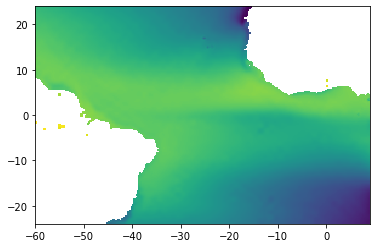

In [20]:
lon = data_nc['longitude'][:]
lat = data_nc['latitude'][:]
sst = data_nc['sst'][:,0,:,:]
sst_mean = np.nanmean(sst, axis=0)

plt.figure()
plt.pcolormesh(lon, lat, sst_mean)

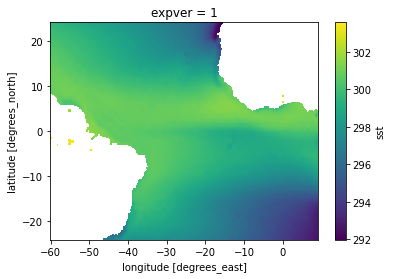

In [24]:
data_xr.isel(expver=0).mean(dim='time')['sst'].plot.pcolormesh()

Com poucas linhas criamos uma figura já com algumas customizações que são baseadas nos atributos do Dataset.

**note**: coordenadas são ticklabels!

In [ ]:
# se estiver no google colab, rode:
!wget --directory-prefix=../dados/ https://raw.githubusercontent.com/nilodna/python-basico/feature_iojr-shortcourse/dados/nino34_ERA5.nc

In [25]:
ds = xr.open_dataset('../dados/nino34_ERA5.nc')

**Acessando atributos:** ```.attrs()```

Funciona tanto para dados (variáveis), quanto para coordenadas e dimensões.

In [30]:
# ds['sst'].attrs
# ds.coords['longitude'].attrs
ds.latitude.attrs

{'units': 'degrees_north', 'long_name': 'latitude'}

### Extraindo dados por indexamento

- similar ao pandas

In [33]:
# selecionar registros para um ano específico
# ds.sel(time='2010-08')

# selecionando tempo com o comando slice (recorte)
ds.sel(time=slice('2010','2019'))

<xarray.Dataset>
Dimensions:    (expver: 2, latitude: 41, longitude: 201, time: 120)
Coordinates:
  * longitude  (longitude) float32 -170.0 -169.75 -169.5 ... -120.25 -120.0
  * latitude   (latitude) float32 5.0 4.75 4.5 4.25 ... -4.25 -4.5 -4.75 -5.0
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2019-12-01
Data variables:
    sst        (time, expver, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-30 21:02:53 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [37]:
# selecionar uma coordenada específica, utilizando o método do
# mais próximo. 
# ds.sel(longitude=-130, latitude=-2.5, method='nearest')

# Note que sem o método 'nearest', não é encontrado nenhum  valor
ds.sel(longitude=-40, latitude=-30)

KeyError: -40.0

**Position-based indexing**: .isel()

- indexação (posição) referente à matriz 1D da coordenada/dimensão

In [40]:
# seleção com base no tempo
ds.isel(time=0, expver=0)['sst']

<xarray.DataArray 'sst' (latitude: 41, longitude: 201)>
array([[301.54486, 301.42084, 301.32318, ..., 299.33298, 299.38376, 299.40622],
       [301.42377, 301.29584, 301.14935, ..., 299.24216, 299.29294, 299.30954],
       [301.33295, 301.1855 , 301.03998, ..., 299.13376, 299.16794, 299.18356],
       ...,
       [302.15912, 302.12006, 302.05365, ..., 298.51465, 298.46484, 298.43555],
       [302.21185, 302.1718 , 302.1347 , ..., 298.6328 , 298.583  , 298.52637],
       [302.24506, 302.21674, 302.1806 , ..., 298.71582, 298.68164, 298.62305]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -170.0 -169.75 -169.5 ... -120.25 -120.0
  * latitude   (latitude) float32 5.0 4.75 4.5 4.25 ... -4.25 -4.5 -4.75 -5.0
    expver     int32 1
    time       datetime64[ns] 1979-01-01
Attributes:
    units:      K
    long_name:  Sea surface temperature

In [41]:
# seleção de uma coordenada pelo índice desta na coordenada referente
ds.isel(longitude=10, latitude=10)

<xarray.Dataset>
Dimensions:    (expver: 2, time: 500)
Coordinates:
    longitude  float32 -167.5
    latitude   float32 2.5
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-08-01
Data variables:
    sst        (time, expver) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-30 21:02:53 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

### Cálculos de alto nível

- groupby
- resample
- rolling

In [42]:
# agrupamento temporal por ano, aplica-se a média
ds.groupby('time.year').mean()

<xarray.Dataset>
Dimensions:    (expver: 2, latitude: 41, longitude: 201, year: 42)
Coordinates:
  * longitude  (longitude) float32 -170.0 -169.75 -169.5 ... -120.25 -120.0
  * latitude   (latitude) float32 5.0 4.75 4.5 4.25 ... -4.25 -4.5 -4.75 -5.0
  * expver     (expver) int32 1 5
  * year       (year) int64 1979 1980 1981 1982 1983 ... 2017 2018 2019 2020
Data variables:
    sst        (year, expver, latitude, longitude) float32 301.74 ... 298.08316

In [44]:
# agrupamento temporal por estação do ano, aplica-se a média
ds.groupby('time.season').mean()

<xarray.Dataset>
Dimensions:    (expver: 2, latitude: 41, longitude: 201, month: 12)
Coordinates:
  * longitude  (longitude) float32 -170.0 -169.75 -169.5 ... -120.25 -120.0
  * latitude   (latitude) float32 5.0 4.75 4.5 4.25 ... -4.25 -4.5 -4.75 -5.0
  * expver     (expver) int32 1 5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst        (month, expver, latitude, longitude) float32 301.26395 ... nan

In [45]:
# reamostragem de mensal para anual, aplica-se a média
ds.resample(time='Y').mean()

<xarray.Dataset>
Dimensions:    (expver: 2, latitude: 41, longitude: 201, time: 42)
Coordinates:
  * time       (time) datetime64[ns] 1979-12-31 1980-12-31 ... 2020-12-31
  * longitude  (longitude) float32 -170.0 -169.75 -169.5 ... -120.25 -120.0
  * latitude   (latitude) float32 5.0 4.75 4.5 4.25 ... -4.25 -4.5 -4.75 -5.0
  * expver     (expver) int32 1 5
Data variables:
    sst        (time, expver, latitude, longitude) float32 301.74 ... 298.08316

In [51]:
# média móvel de 3 meses
ds.rolling(time=3).mean()

<xarray.Dataset>
Dimensions:    (expver: 2, latitude: 41, longitude: 201, time: 500)
Coordinates:
  * longitude  (longitude) float32 -170.0 -169.75 -169.5 ... -120.25 -120.0
  * latitude   (latitude) float32 5.0 4.75 4.5 4.25 ... -4.25 -4.5 -4.75 -5.0
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-08-01
Data variables:
    sst        (time, expver, latitude, longitude) float32 nan nan ... nan nan

# Cálculo do Índice do El Niño 3.4

[[fonte]](https://ncar.github.io/PySpark4Climate/tutorials/Oceanic-Ni%C3%B1o-Index/#Computational-Recipe)

Receita da lógica/algoritmo:
- média espacial na região do Niño 3.4 (ponderada pela lat/lon)
- cálculo da climatologia mensal
- cálculo da anomalia da média espacial
- média móvel de 3 meses para suavização

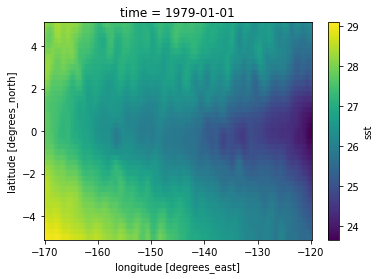

In [52]:
# leitura de arquivos ERA5
ds = xr.open_dataset('../dados/nino34_ERA5.nc')
ds = ds.mean(dim='expver')

# converter de Kelvin para oC
ds['sst'] -= 273.15

ds.isel(time=0).sst.plot.pcolormesh()

In [54]:
def global_mean_sst(dset):
    # source: https://ncar.github.io/PySpark4Climate/tutorials/Oceanic-Ni%C3%B1o-Index/#Computational-Recipe
    # Find mean temperature for each latitude
    mean_sst_lat = dset.sst.mean(dim='longitude')

    # Find Weighted mean of those values
    num = (np.cos(dset.latitude) * mean_sst_lat).sum(dim='latitude')
    denom = np.sum(np.cos(dset.latitude))

    # Find mean global temperature
    mean_global_temp = num / denom

    return mean_global_temp

In [57]:
# média espacial ingênua, necessário ponderar pela coordenadas,
# pois a variação de lat/lon implica em uma área diferente
ds_avg_1 = ds.mean(dim=['latitude', 'longitude'])
ds_avg_2 = global_mean_sst(ds)

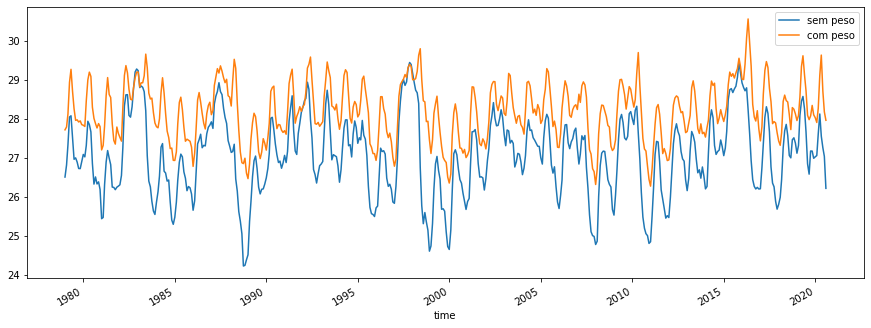

In [59]:
# diferença entre os dois tipos de média espacial
fig,ax = plt.subplots(figsize=(15,5))

ds_avg_1.sst.plot(ax=ax, label='sem peso')

ds_avg_2.plot(ax=ax, label='com peso')

plt.legend()

In [72]:
# climatologia utilizando groupby
ds_clim = ds_avg_1.sel(time=slice('1980','2016')).groupby('time.month').mean('time')
ds_clim

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month) float32 26.499523 26.650063 ... 26.707314 26.577724

In [74]:
# anomalia espacial utilizando o groupby sem método estatístico
ds_anom = ds_avg_1.groupby('time.month') - ds_clim

# ds_anom.plot(figsize=(15,5))

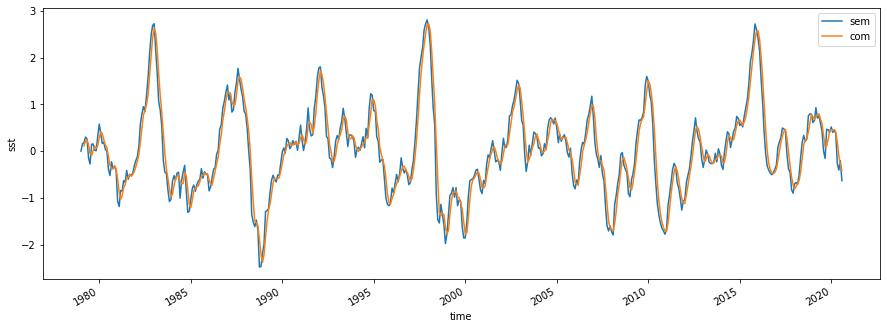

In [77]:
# suavização com média móvel de 3 meses para calcular o 
# Oceanic Nino Index (ONI)
ds_oni = ds_anom.rolling(time=3).mean()

fig,ax = plt.subplots(figsize=(15,5))
ds_anom.sst.plot(ax=ax, label='sem')
ds_oni.sst.plot(ax=ax, label='com')
plt.legend()

### Bonus: vamos comparar com o ONI da NOAA (oficial)

In [78]:
# getting the ONI computed by NOAA from the website
url = 'https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt'

oni = pd.read_csv(url, sep='\s+')
dt = pd.date_range(start='1950-01', end='2020-10', freq='M')
oni.index = dt

oni = oni.drop(['SEAS', 'YR'], axis=1)
oni

,TOTAL,ANOM
1950-01-31,24.72,-1.53
1950-02-28,25.17,-1.34
1950-03-31,25.75,-1.16
1950-04-30,26.12,-1.18
1950-05-31,26.32,-1.07
...,...,...
2020-05-31,27.74,-0.01
2020-06-30,27.34,-0.25
2020-07-31,26.87,-0.40
2020-08-31,26.37,-0.62


In [79]:
ONI = xr.Dataset()
ONI['time'] = ds_oni.time
ONI['oni_era5'] = (('time'), ds_oni.sst.values)
ONI['oni_noaa'] = (('time'), oni['1979':'2020-08']['ANOM'].values)
ONI

<xarray.Dataset>
Dimensions:   (time: 500)
Coordinates:
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 10 11 12 1 2 3 4 5 6 7 8
  * time      (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-08-01
Data variables:
    oni_era5  (time) float32 nan nan 0.11336517 ... -0.2890142 -0.413105
    oni_noaa  (time) float64 0.03 0.07 0.2 0.28 0.23 ... -0.01 -0.25 -0.4 -0.62

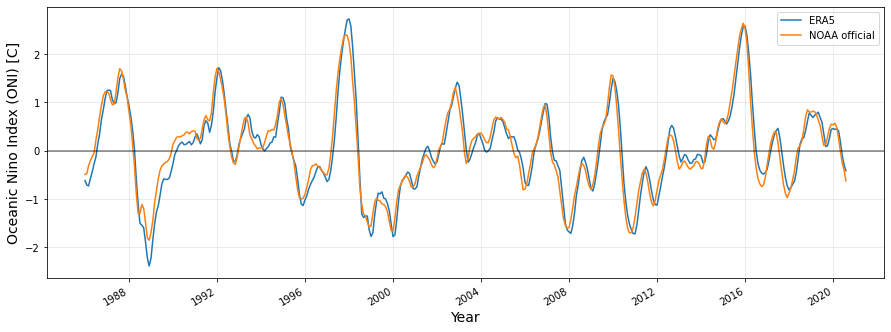

In [81]:
fig,ax = plt.subplots(figsize=(15,5))

ONI.sel(time=slice('1986', '2020'))['oni_era5'].plot(ax=ax, label='ERA5')
ONI.sel(time=slice('1986', '2020'))['oni_noaa'].plot(ax=ax, label='NOAA official')

ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Oceanic Nino Index (ONI) [C]", fontsize=14)
plt.axhline(0, c='k', alpha=.5)
plt.grid('--', alpha=.3)
plt.legend()

In [82]:
from scipy.io import loadmat

loadmat?